# Multiple plotting of modules parameters, acquired by the flash test technique, after different treatments

### Introduction
This programm plots the module parameters versus the irradiance for various module treatment. The parameters are acquired using the flash test method.
<br/>
The module parameters, as well as the I/V curves, are stored in .csv files which names obeys the following format:
- UUUdddd_ddddW_Td.csv with U=[A-Z,-,_] and d=[1-9]. We have:
  - UUUdddd_dddd is the module type the number of U is unlimited  and the  the number of digits d is limited to 50
  - ddddW is the irradiande in W/m^2. The number of digits d must be equal to 4.
  - Td is the treatment label. The numer of digit d is equal to 1.
  
These files are stored in the *data_folder* and all its sub folders. By default *data_folder* is set to *WORKING_DIR*= ~/PVcharacterization_files/flash test. This path is stored in the  configuration file *Pvcharacterization.yaml*. 

The structure of the WORKING_DIR must obeys the following structure:
<pre>WORKING_DIR
├── exp_summary.xlsx
├── pv.db
├── BOREALIS
│   ├── LC-BOREALIS-03_0200W_T0.csv
│   ├── LC-BOREALIS-03_0200W_T1.csv
│   └── ...
├── IVcurves
│   ├── EM7621190702200776_1000W_T0.csv
│   ├── EM7621190702200776_1000W_T3.csv
│   └── ...
├── JINERGY
│   ├── JInergy035
│   │   ├── JINERGY3272023326035_0200W_T0.csv
│   │   ├── JINERGY3272023326035_0200W_T1.csv
│   │   └── ....
│   ├── JInergy060
│   │   ├── JINERGY3272023326060_0200W_T0.csv
│   │   ├── JINERGY3272023326060_0200W_T1.csv
│   │   └──...
│   └── JInergy063
│       ├── JINERGY3272023326063_0200W_T0.csv
│       ├── JINERGY3272023326063_0200W_T1.csv
│       └── ...</pre> 
Where *pb.db* is a sqlite database containing two tables.


### Description
</br></br>
The program:
1. Interactevelly defines the *data_folder* where *data_folder* must be locate is the users home directory.
2. Recursivelly builds the list of all .csv file located in the folder *data_folder* and its sub-folders.
3. Interactivelly selects the list modules to be analysed and build the dataframe *df_meta* containing all the data necessary to the plotting of the modules parameters
4. Interactivelly defines the list of tuple [(T(i),T(j))], where T(i) stands for the ieme treatment.
5. Interactivelly convert the symbolic items T(i) into the name of the treatment.
6. For *n_params* parameters interactivelly sectected plots the *n_params* the parameters relative variation between two treatments T(k) and T(h):
    
   $$100\frac{{Para{m_i}(Irradiance(n);T(h),module(m)) - Para{m_i}(Irradiance(n);T(k),module(m))}}{{Para{m_i}(Irradiance(n);T(k),module(m))}}$$
   
### Module description
   
The program relies on the package *PVcharacterization_Utils* containig the following modules:
1. PVcharacterization_GUI 
    - input_treatment_labels
    - select_items
    - select_files
    - select_data_dir
2. PVcharacterization_flashtest 
    - assess_path_folders
    - batch_filename_correction
    - build_files_database
    - build_metadata_dataframe
    - build_modules_filenames
    - build_modules_list
    - correct_filename
    - data_dashboard
    - parse_filename
    - pv_flashtest_pca
    - read_flashtest_file
3. PVcharacterization_global 
    - DEFAULT_DIR (Path.home())
    - DATA_BASE_NAME
    - DATA_BASE_TABLE_FILE
    - DATA_BASE_TABLE_EXP
    - COL_NAMES
    - PARAM_UNIT_DIC
    - IRRADIANCE_DEFAULT_LIST
    - TREATMENT_DEFAULT_LIST
4. PVcharacterization_image (not used)
    - crop_image
    - py2gwyddion
    - read_electolum_file
5. PVcharacterization_plot
    - construct_x_y
    - init_plot_diff
    - plot_params 
    - plot_params_diff
    - plot_iv_power
6. PVcharacterization_database
    - add_files_to_database
    - sieve_files
    - suppress_duplicate_database
    - sqlite_to_dataframe
    - df2sqlite
    
### How use the package
1. Define you working directory name *data_folder*
2. Create/modify the sqlite database
3. Than you can:
   - Perform PCA analysis
   - I/V curves plotting
   - Parameters plotting
   - ...
    
### Nomenclature:
 - module-type (mod): ex. QCELL-2739, QCELLS901719162417702739
 - parameters (param): ex. Pmax, Voc, Isc, Fill Factor, Rseries
 - irradiance (irr): irradiance in W/m^2 
 - treatment (trt): treatment type T0, T1, T2,T2,...

In [1]:
''' 
    Creation: 2021.11.14
    Last update: 

    Choose the working directory

'''

# Local imports 
import PVcharacterization_Utils as pv

change_working_folder = input(f'Your working directory is {pv.WORKING_DIR} do you want to change (y,n)?')
if change_working_folder=='y':
    data_folder = pv.assess_path_folders()
    pv.change_config_pvcharacterization(data_folder)
else:
    data_folder = pv.WORKING_DIR

Your working directory is C:\Users\franc\PVcharacterization_files\flash test do you want to change (y,n)?n


In [4]:
''' 
    Creation: 2021.09.13
    Last update: 2021.11.13

    User specific paths definition

'''

# Standard library imports
import os
from pathlib import Path

# Local imports 
import PVcharacterization_Utils as pv

if not(os.path.isfile(Path(data_folder) / Path(pv.DATA_BASE_NAME))):
    pv.build_files_database(data_folder)
    pv.build_metadata_dataframe(data_folder)
    print('builds the database {Path(data_folder) / Path(pv.DATA_BASE_NAME)}')
    
else:
    new_database = input(f'The database {pv.DATA_BASE_NAME} already exits do you want to overwrite it (y,n)?')  
    if new_database == 'y':
        pv.build_files_database(data_folder)
        pv.build_metadata_dataframe(data_folder)
    else:
        add_to_database = input(f'Do you want to add file(s) to the database (y,n)?')  
        if add_to_database == 'y':
            pv.add_exp_to_database(data_folder)
        
# Correction of wrong filenames
filename_correct = 'n'
filenames_correct = input('Correction of filenames (y,n)?')
if filenames_correct=='y':
    verb = False
    status = pv.batch_filename_correction(data_folder, verbose=verb)
    print(status)

The database pv.db already exits do you want to overwrite it (y,n)?y
Only the first occurrence(s) will be retained.

295 flash test files detected.
13 duplicates suppressed
The database table PV_descp in C:\Users\franc\PVcharacterization_files\flash test\pv.db is built


Correction of filenames (y,n)?n


In [ ]:
''' Creation: 2021.10.17
    Last update: 2021.11.13
    
    df_meta dataframe building from selected files in database DATA_BASE_NAME
    and PCA analysis
    
'''
# Local imports
import PVcharacterization_Utils as pv

df_meta = pv.build_metadata_df_from_db(data_folder)
print(df_meta.describe())
df_meta_pca = pv.pv_flashtest_pca(df_meta,scree_plot = False,interactive_plot=True)

In [ ]:
''' Creation: 2021.10.03
    Last update: 2021.11.13
    
    Interactive choice of the treatment differences
    
    ''' 
# Local imports
import PVcharacterization_Utils as pv

plot_param_dict = {'markers': ["o", "+", "s", "<", ">", "p", "1", "2", "3", "4"],
                     'marker_colors': ['#0000A0','#1569C7','#78f89d','#FFEB3B','#E64A19'],
                     'marker_size': 80,
                     'legend_fontsize': 14,
                     'ticks_fontsize': 12,
                     'labels_fontsize': 12,
                     'title_fontsize':16,
                     'fig_width': 12, 
                     'fig_height_unit': 2,
                     'fig_title_height': 1,
                     'bbox_x0': 0.25, 
                     'bbox_y0': 0.25, 
                     'bbox_width': 1, 
                     'bbox_height': 1,
                     'irr_add_nbr':0.5}

df_meta = pv.build_metadata_df_from_db(data_folder)
list_diff = pv.init_plot_diff(df_meta)
dic_trt_meaning = pv.input_treatment_labels(list_diff)
pv.plot_params_diff(df_meta,
                    list_diff,
                    None,
                    dic_trt_meaning,
                    long_label=False,
                    plot_params_dict=plot_param_dict)


In [ ]:
''' Creation: 2021.09.19
    Last update: 2021.10.22
    
    Plotting of I/V curves.
    
    ''' 
# Local imports
import PVcharacterization_Utils as pv

df_files_descp = pv.sqlite_to_dataframe(data_folder,pv.DATA_BASE_TABLE_FILE)
list_mod_selected = pv.build_modules_list(df_files_descp,data_folder)
irr_select = [200,400,600,800,1000,2000,4000]
trt_select = ["T0", "T1", "T2", "T3", "T4"]
pv.plot_iv_curves(irr_select,list_mod_selected,trt_select,data_folder)

In [ ]:
''' Creation: 2021.10.20
    Last update: 2021.11.13
Build a dashboard

'''
# Local imports
import PVcharacterization_Utils as pv

#df_files_descp = pv.sqlite_to_dataframe(data_folder,pv.DATA_BASE_TABLE_FILE)
list_params = ['Pmax']#,'Voc','Isc','Fill Factor','Rseries',]
df_meta_dashboard =  pv.data_dashboard(data_folder,list_params)
df_meta_dashboard

In [ ]:
'''Creation: 2021.11.03
    Last update: 2021.11.04
Plot IV curves
'''
# 3rd party imports
import matplotlib.pyplot as plt

# Local imports
import PVcharacterization_Utils as pv

# Get dataframe describing the experimental files
df_files_descp = pv.sqlite_to_dataframe(data_folder,pv.DATA_BASE_TABLE_FILE)   

# Select the module types which names has to be corrected
list_mod_selected = pv.build_modules_list(df_files_descp,data_folder)
iv_curve = {pv.parse_filename(file): pv.read_flashtest_file(file).IV0 
            for file in pv.build_modules_filenames(list_mod_selected,data_folder)}

colors = {'T0':'r','T3':'k'}
markers = {'EM7621190702200776':'x',
           'EM7621190702200818':'x',
           'SERAPHIM-EM7621190702200646':'v',
           'SERAPHIM-EM7621190702200656':'v'}
fig = plt.figure(figsize=(15,15))
for name,value in iv_curve.items():
    if name.treatment in ['T0','T3'] and name.irradiance==1000:
        plt.scatter(value["Voltage"][::70],
                    value["Current"][::70],
                    s=80,
                    label=f'{name.module_type} {name.treatment}',
                    c=colors[name.treatment],
                    marker=markers[name.module_type],
                    alpha=1)
    
_ = plt.legend()

In [ ]:
'''Creation: 2021.11.03
    Last update: 2021.11.09
Builds a dadaframe with ff,ff_cor,Isc,Isc_cor,100(ff_cor-ff)/ff_cor
Finds the maximum value of 100(ff_cor-ff)/ff_cor
Plots histogram and power I/V curves 
'''
# Standard library imports
from pathlib import Path

#3rd party imports
import matplotlib.pyplot as plt

# Local imports
import PVcharacterization_Utils as pv


df_meta = pv.build_metadata_df_from_db(data_folder)
plt.title(f'{len(df_meta)} experiments')
df_meta['ecart_ff_pc'] = df_meta.apply(lambda x: 100*(x['Fill Factor_corr']-x['Fill Factor'])/x['Fill Factor_corr'],axis=1)
dg = df_meta.query('ecart_ff_pc>0.1')
_ = plt.hist(df_meta['ecart_ff_pc'],bins=30)
plt.xlabel('$100(FF_{cor} - FF)/FF_{cor}$ (%)')
idmax = df_meta['ecart_ff_pc'].idxmax(axis=0)

path_database = data_folder / Path(pv.DATA_BASE_NAME)
files = pv.sieve_files([df_meta.loc[idmax,'irradiance']],
                       [df_meta.loc[idmax,'treatment']],
                       [df_meta.loc[idmax,'module_type']],
                       path_database)

pv.plot_iv_power(files[0] )

In [ ]:
#3rd party imports
import matplotlib.pyplot as plt

# Local imports
import PVcharacterization_Utils as pv

df_meta = pv.build_metadata_df_from_db(data_folder)
g = df_meta.pivot(values= ['Pmax','irradiance'],index=['module_type','treatment',],
              columns=['irradiance',]) 
x = g.loc[g.index[0][0],g.index[0][1]] ['irradiance'].to_numpy()
y = g.loc[g.index[0][0],g.index[0][1]] ['Pmax'].to_numpy()
_ = plt.scatter(x,y)
_ = plt.title(f'module:{g.index[0][0]}, treatment: {g.index[0][1]}')
_  = plt.xlabel('irradiance(W/cm^2)')
_ = plt.ylabel('Power (W)')

In [ ]:
x = ['A','B','C','D']
y= ['B','D']
list(set(x).intersection(set(y)))

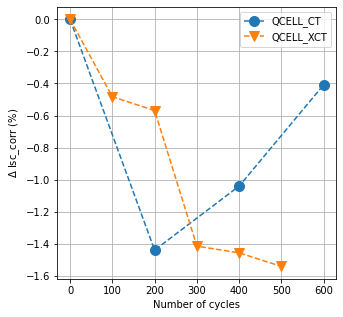

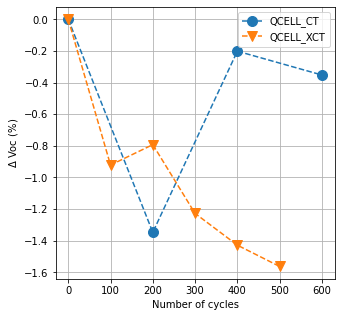

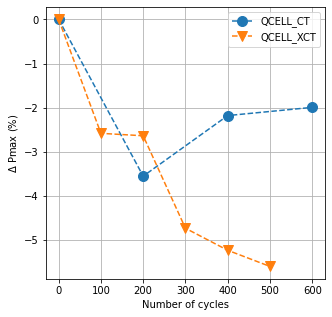

In [8]:
def compute_parameter_relative_diff(df_meta,irradiance, module_type_tag, parameter):
    
    '''Computes:
    100[parameter(TI;irradiance,module_type)-parameter(T0;irradiance,module_type)]/parameter(T0;irradiance,module_type)
    for all TI such that the string module_type_tag is part of the experiment name.
    
    Args:
      df_meta (dataframe): The columns contain the parameter values and the experimental conditions 
          and the row the experiment key.
      irradiance (int): The value of the irradiance used for the experiment.
      module_type_tag (str): A string contained in the module_type.
      parameter (str): The parameter of interest.
      
    Returns
      (namedtuple) a named tuple containing the list of treatments and the list of parameter relative variations.
      
    '''
    
    # Standard library imports
    from collections import namedtuple


    param_diff = namedtuple(
        "param_diff",
        ["treatment", "delta_param"],
    )
    
    df_meta_m = df_meta[(df_meta['module_type'].str.contains(module_type_tag)) &
                        (df_meta['irradiance'] == irradiance)] 
    treatment = df_meta_m['treatment'].tolist()
    param = df_meta_m[parameter].tolist()
    delta_param = [100*(x-param[0])/param[0] for x in param]
    
    return param_diff(treatment,delta_param)
    

import matplotlib.pyplot as plt

df_meta = pv.build_metadata_df_from_db(data_folder)

qcell_ct = ['731', '764']     # QCELL CT
qcell_xct =  ['749', '754']   # QCELL XCT

dic_ct = {'T0':0,'T1':200, 'T2':400, 'T3':600} # treatment: number of cycles for CT
dic_xct = {'T0':0,'T1':100, 'T2':200, 'T3':300,'T4':400,'T5':500} # treatment: number of cycles for XCT

irradiance = 1000
idx=1 # choose qcell_ct[idx], qcell_xct[idx]

for parameter in ['Isc_corr', 'Voc', 'Pmax']:
    
    # Treat CT
    fig =plt.figure(figsize=(5,5))
    module_name = qcell_ct[idx]
    param_diff = compute_parameter_relative_diff(df_meta,irradiance, module_name, parameter)
    nbr_treatment =[dic_ct[x] for x in param_diff.treatment]
    plt.plot(nbr_treatment,param_diff.delta_param,'--o',label="QCELL_CT",markersize=10)
    plt.grid(True)
    
    # Treat XCT
    module_name =qcell_xct[idx]
    param_diff = compute_parameter_relative_diff(df_meta,irradiance, module_name, parameter)
    nbr_treatment =[dic_xct[x] for x in param_diff.treatment]
    plt.plot(nbr_treatment,param_diff.delta_param,'--v',label="QCELL_XCT",markersize=10)
    plt.xlabel('Number of cycles')
    plt.ylabel(f'$\Delta$ {parameter} (%)')
    plt.legend()

